<a href="https://colab.research.google.com/github/devashish10397/sdxl_turbo_gradio/blob/main/sdxl_turbo_diffusers_gradio_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q diffusers transformers accelerate peft gradio==3.50.2

In [ ]:
import matplotlib.pyplot as plt

from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")

In [ ]:
import os
import shlex
import subprocess
from pathlib import Path
from typing import Union

id_rsa_file = "/content/id_rsa"
id_rsa_pub_file = "/content/id_rsa.pub"
if os.path.exists(id_rsa_file):
    os.remove(id_rsa_file)
if os.path.exists(id_rsa_pub_file):
    os.remove(id_rsa_pub_file)

def gen_key(path: Union[str, Path]) -> None:
    path = Path(path)
    arg_string = f'ssh-keygen -t rsa -b 4096 -N "" -q -f {path.as_posix()}'
    args = shlex.split(arg_string)
    subprocess.run(args, check=True)
    path.chmod(0o600)

gen_key(id_rsa_file)

In [ ]:
import threading
def tunnel():
  !ssh -R 80:127.0.0.1:7860 -o StrictHostKeyChecking=no -i /content/id_rsa remote.moe
threading.Thread(target=tunnel, daemon=True).start()


In [ ]:
import gradio as gr

def generate(prompt):
  image = pipe(prompt, num_inference_steps=1, guidance_scale=0.0, width=512, height=512).images[0]
  display_image(image)
  return image.resize((1024, 1024))

def display_image():
    image = pipe("Create a Real Image of New York City set on fire", num_inference_steps=1, guidance_scale=0.0, width=512, height=512).images[0]
    plt.imshow(image)
    plt.axis('off')
    plt.show()



def launch():
  with gr.Blocks(title=f"Realtime SDXL Turbo", css=".gradio-container {max-width: 544px !important}") as demo:
      with gr.Row():
        with gr.Column():
            textbox = gr.Textbox(show_label=False, value="New York City set on fire while snowing newar times square")
            button = gr.Button()
      with gr.Row(variant="default"):
          output_image = gr.Image(
              show_label=False,
              type="pil",
              interactive=False,
              height=512,
              width=512,
              elem_id="output_image",
          )

      # textbox.change(fn=generate, inputs=[textbox], outputs=[output_image], show_progress=False)
      button.click(fn=generate, inputs=[textbox], outputs=[output_image], show_progress=False)

  demo.queue().launch(inline=False, share=True, debug=True)

  0%|          | 0/1 [00:00<?, ?it/s]

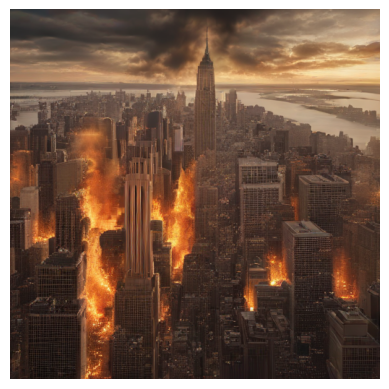

In [ ]:
display_image()

In [ ]:
launch()